# DPU : Resnet50 trained on Tipu12
----

## 0. Extract dataset
We extract the dataset if needed.

In [2]:
import os
import time
import numpy as np
import threading
import cv2
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from matplotlib.colors import Normalize
from matplotlib.cm import ScalarMappable
%matplotlib inline

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


The following functions plot graphs including accuracy per class, confusion matrix and f1 score. 

In [4]:
def plot_accuracy_per_class(accuracy, class_accuracy, class_names, board, num_thread):
    # Normalize accuracies for colormap
    norm = Normalize(vmin=0, vmax=1)
    sm = ScalarMappable(cmap='RdYlGn', norm=norm)
    sm.set_array([])

    class_accuracy_denormalized = [acc * 100 for acc in class_accuracy]

    # Attribute colors depending on accuracies value
    colors = [sm.to_rgba(acc) for acc in class_accuracy]

    # Create graph
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)
    plt.xlabel('Class')
    plt.ylabel('Accuracy (%)')
    if num_thread == 1:
        plt.title(f'Accuracy per Class - {board} - {num_thread} thread')
    else:
        plt.title(f'Accuracy per Class - {board} - {num_thread} threads')
    plt.xticks(rotation=90) 
    plt.colorbar(sm, ax=ax, label='Accuracy')

    # Add accuracy on top
    for i, acc in enumerate(class_accuracy_denormalized):
        ax.text(i, acc + 2, f'{acc:.2f}%', ha='center', va='bottom')

    # Add mean accuracy
    plt.text(len(class_names) - 1, max(class_accuracy_denormalized) + 5, f'Mean Accuracy: {accuracy * 100:.2f}%', ha='center', fontsize=12, bbox=dict(facecolor='white', edgecolor='black'))

    plt.tight_layout()
    plt.savefig(f'/home/anthony/accuracy_per_class_{board}_{num_thread}_thread.png')
    plt.show()

In [5]:
def confusion_matrix_stats(conf_mat):
    # Counting true positives, false positives, true negatives, and false negatives
    true_positives = np.diag(conf_mat)
    false_positives = np.sum(conf_mat, axis=1) - true_positives
    false_negatives = np.sum(conf_mat, axis=0) - true_positives
    true_negatives = np.sum(conf_mat) - true_positives - false_positives - false_negatives
    # F1 Score
    f1_score = np.where((true_positives + false_positives + false_negatives) > 0, 2 * true_positives / (2 * true_positives + false_positives + false_negatives), 0)
    
    return f1_score, true_positives, false_positives, false_negatives, true_negatives

def compute_f1_score(labels_list, predictions_list):
    conf_mat = confusion_matrix(labels_list, predictions_list)
    f1_score, true_positives, false_positives, false_negatives, true_negatives = confusion_matrix_stats(conf_mat)
    f1_score_mean = np.mean(f1_score[:])
    
    return conf_mat, f1_score, f1_score_mean

def plot_f1_score(class_names, f1_score, f1_score_mean, num_thread, board):
    plt.figure(figsize=(12, 8))
    ax = sns.barplot(x=class_names, y=f1_score, palette="Blues_d")
    plt.xlabel('Class')
    plt.ylabel('F1 Score')
    if num_thread == 1:
        plt.title(f'F1 Score per Class - {board} - {num_thread} thread')
    else:
        plt.title(f'F1 Score per Class - {board} - {num_thread} threads')
    plt.xticks(rotation=90) 

    # Add the mean F1 score line
    plt.axhline(f1_score_mean, color='red', linestyle='--', label=f'Mean F1 Score: {f1_score_mean:.3f}')

    # Adding the exact F1 score values on top of the bars
    for i, score in enumerate(f1_score):
        ax.text(i, score + 0.01, f'{score:.3f}', ha='center', va='bottom')

    # Add a legend for the mean line
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'/home/anthony/mount2/Vitis-AI/demo/VART/resnet50_mt_py/results/f1_score_per_class_{board}_{num_thread}_thread.png')
    plt.show()
    
def plot_confusion_matrix(conf_mat, class_names, num_thread, board):
    plt.figure(figsize=(10, 8))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    if num_thread == 1:
        plt.title(f'Confusion Matrix - {board} - {num_thread} thread')
    else:
        plt.title(f'Confusion Matrix - {board} - {num_thread} threads')
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()

    # Save the plot
    plt.savefig(f'/home/anthony/mount2/Vitis-AI/demo/VART/resnet50_mt_py/results/confusion_matrix_{board}_{num_thread}_thread.png')
    plt.show()

In [ ]:
# Zybo tensil tipu12

accuracy = 0.7367
class_accuracy = [0.6898, 0.6772, 0.6835, 0.7409, 0.7878, 0.6881, 0.9041, 0.5955, 0.8364, 0.7824, 0.7105, 0.7346]
class_names = ['Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Mantodea', 'Megaloptera', 'Neuroptera', 'Odonata', 'Orthoptera', 'Phasmida', 'Trichoptera']
board = 'Zybo Z7 Tensil'
num_thread = 1
plot_accuracy_per_class(accuracy, class_accuracy, class_names, board, num_thread)

/tmp/ipykernel_354073/4009617731.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)


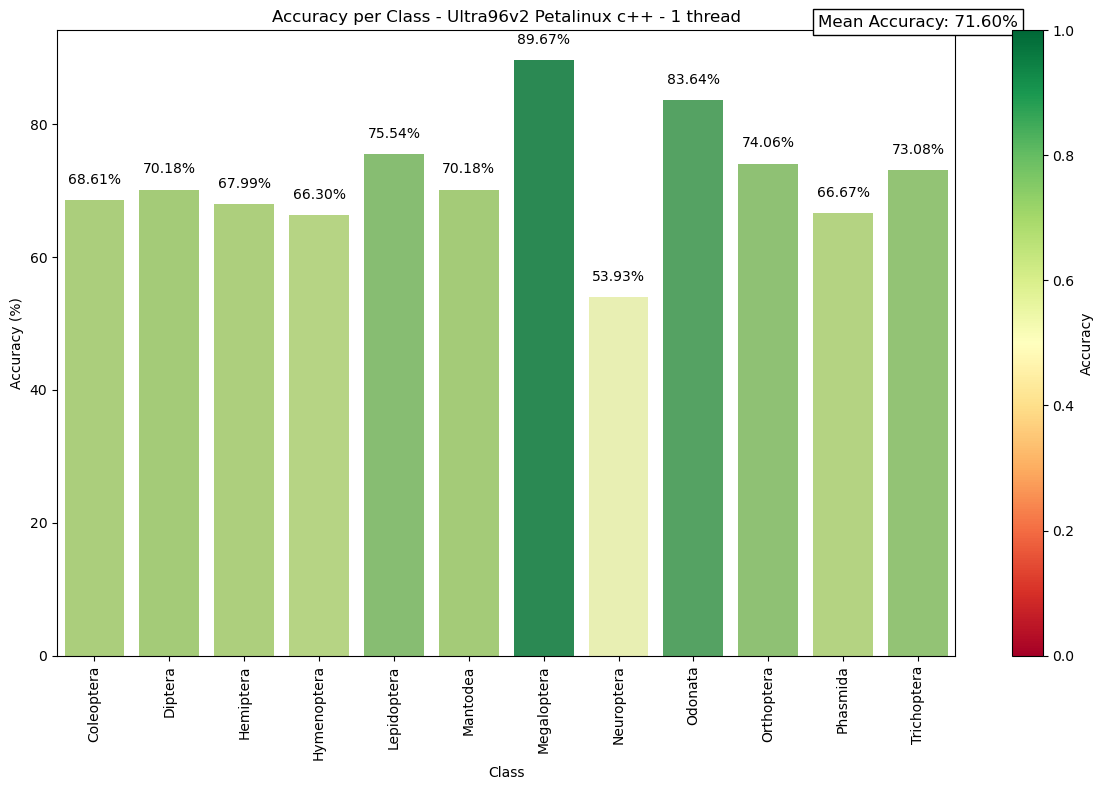

In [13]:
# Ultra96v2 Petalinux CPP

accuracy = 0.7160
class_accuracy = [0.6861, 0.7018, 0.6799, 0.6630, 0.7554, 0.7018, 0.8967, 0.5393, 0.8364, 0.7406, 0.6667, 0.7308]
class_names = ['Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Mantodea', 'Megaloptera', 'Neuroptera', 'Odonata', 'Orthoptera', 'Phasmida', 'Trichoptera']
board = 'Ultra96v2 Petalinux c++'
num_thread = 1
plot_accuracy_per_class(accuracy, class_accuracy, class_names, board, num_thread)

/tmp/ipykernel_362040/1192469465.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)


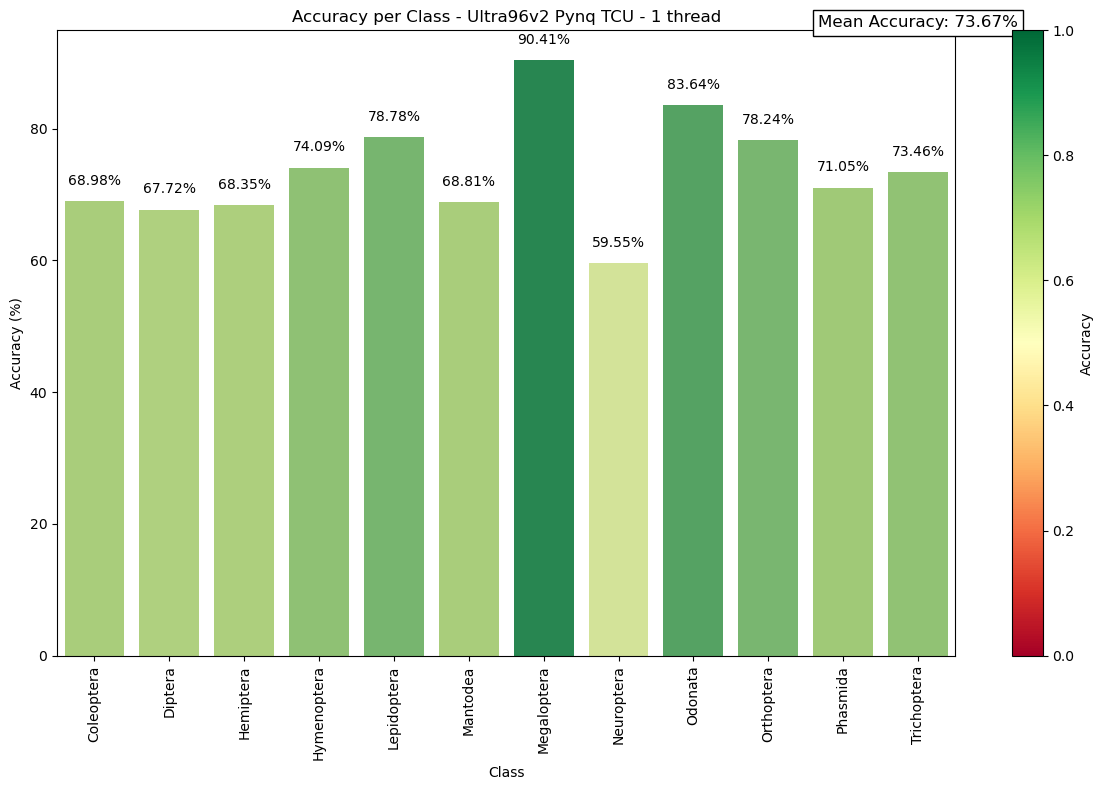

In [6]:
# Ultra96v2 Tensil 

accuracy = 0.7367
class_accuracy = [0.6898, 0.6772, 0.6835, 0.7409, 0.7878, 0.6881, 0.9041, 0.5955, 0.8364, 0.7824, 0.7105, 0.7346]
class_names = ['Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Mantodea', 'Megaloptera', 'Neuroptera', 'Odonata', 'Orthoptera', 'Phasmida', 'Trichoptera']
board = 'Ultra96v2 Pynq TCU'
num_thread = 1
plot_accuracy_per_class(accuracy, class_accuracy, class_names, board, num_thread)

/tmp/ipykernel_354073/4009617731.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=class_accuracy_denormalized, palette=colors)


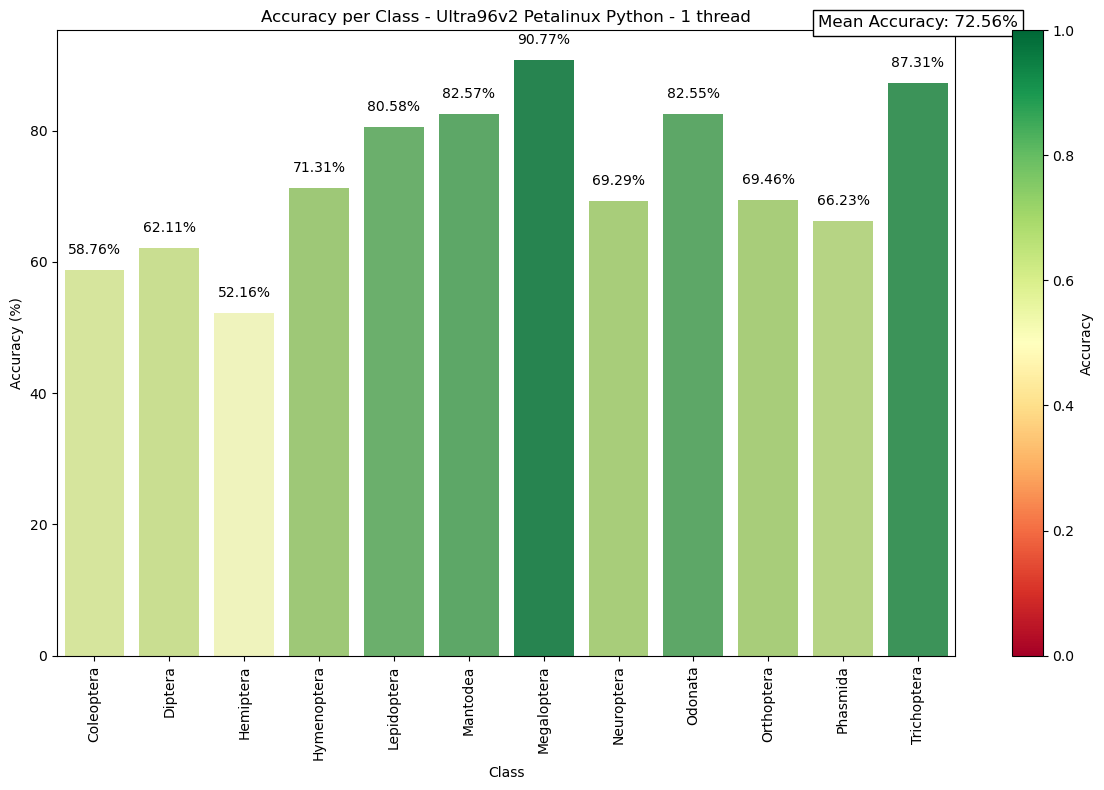

/tmp/ipykernel_354073/924745250.py:21: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=class_names, y=f1_score, palette="Blues_d")


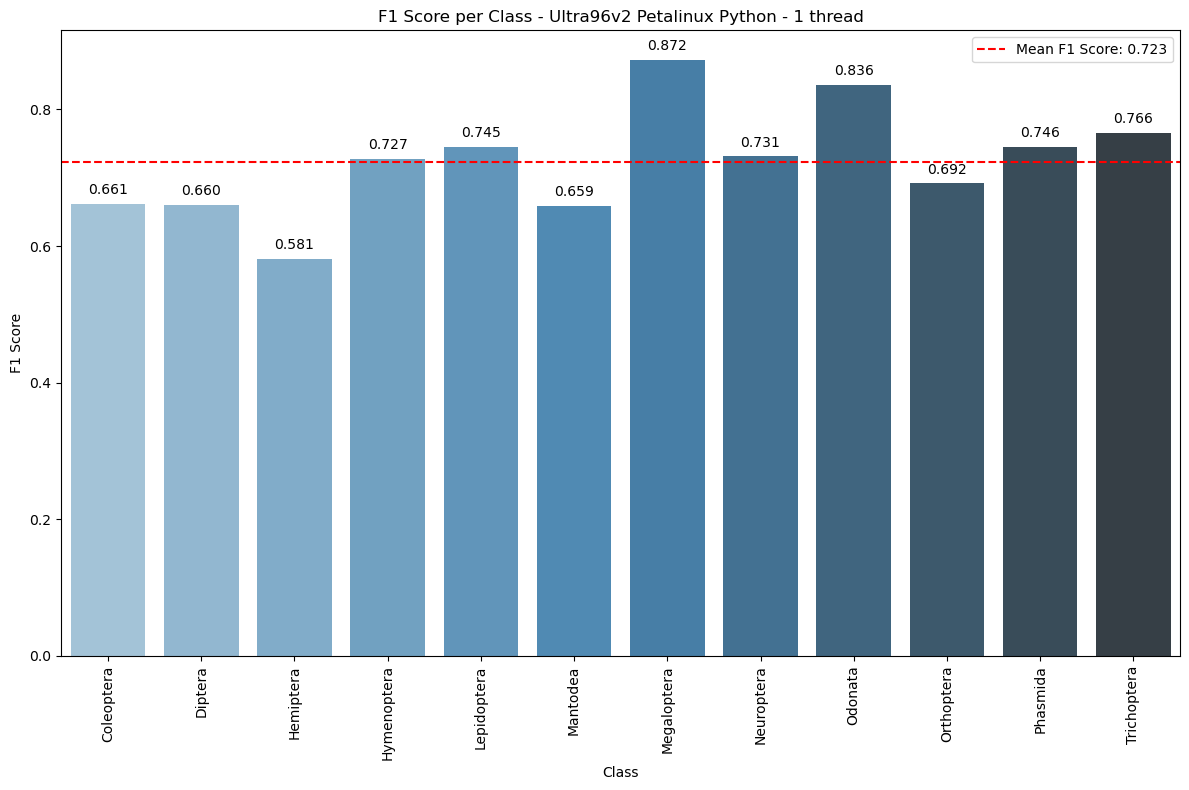

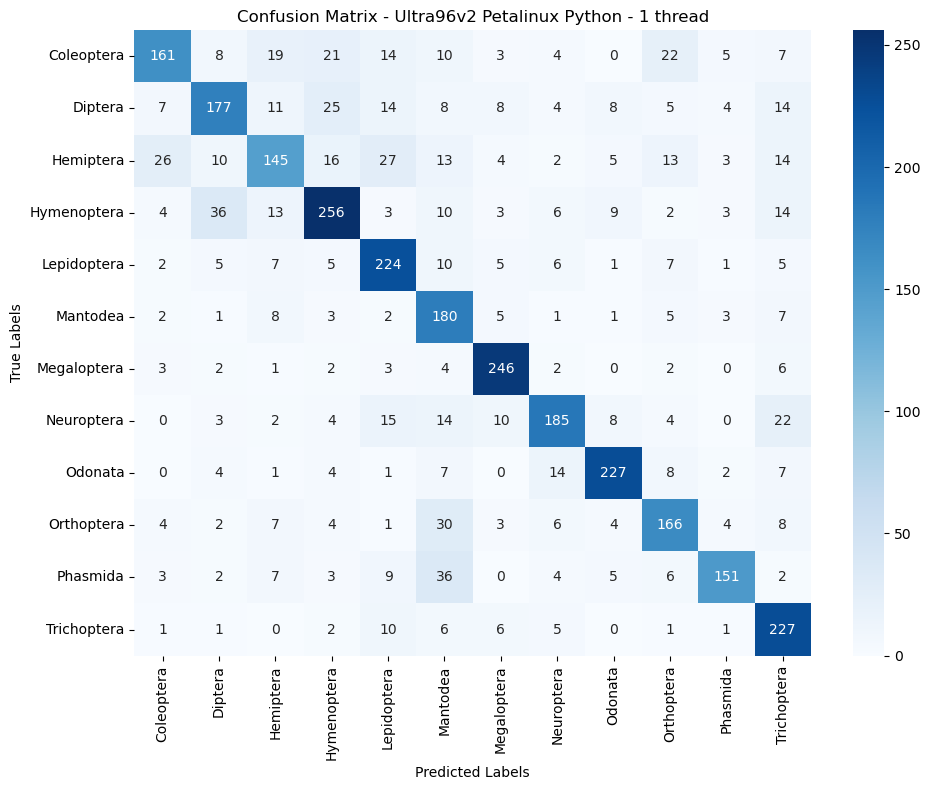

In [12]:
# Ultra96v2 Petalinux Python

accuracy = 0.7256
class_accuracy = np.loadtxt('/home/anthony/mount2/Vitis-AI/demo/VART/class_accuracy.txt')
predictions_list = np.loadtxt('/home/anthony/mount2/Vitis-AI/demo/VART/predictions_list.txt', dtype=str)
labels_list = np.loadtxt('/home/anthony/mount2/Vitis-AI/demo/VART/labels_list.txt', dtype=str)
class_names = ['Coleoptera', 'Diptera', 'Hemiptera', 'Hymenoptera', 'Lepidoptera', 'Mantodea', 'Megaloptera', 'Neuroptera', 'Odonata', 'Orthoptera', 'Phasmida', 'Trichoptera']
board = 'Ultra96v2 Petalinux Python'
num_thread = 1

plot_accuracy_per_class(accuracy, class_accuracy, class_names, board, num_thread)
conf_mat, f1_score, f1_score_mean = compute_f1_score(labels_list, predictions_list)
plot_f1_score(class_names, f1_score, f1_score_mean, 1, board)
plot_confusion_matrix(conf_mat, class_names, 1, board)